# Load & Displays a CT of Lung Scan

In [2]:
import SimpleITK as sitk # pip insatll simpleitk   (conda does not manage pkg)
import numpy as np
import csv
from ipywidgets import interact

import matplotlib.pyplot as plt

from matplotlib.patches import Circle
from matplotlib.pylab import subplots
import matplotlib.patches as patches

%matplotlib inline

In [2]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 10, 10

# SimpleITK

SimpleITK can load the native DICOM files produced by the CT scanner. However, it is often more convienent to save the entire 3D volume to a MHD format.

In [8]:
# relative path to data. Note in .gitignore the data folder has been added. 
# You must make your own data fodler locally.
# You must have the .RAW and .MHD in the same directory

img_filename = '../data/sample/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.mhd'
itk_img = sitk.ReadImage(img_filename)  # Dimensions are ordered as X, Y, Z (height, width, depth)

In [11]:
print('The pixel dimensions are {} mm'.format(itk_img.GetSpacing()))
print('There are {} slices in the CT volume.'.format(itk_img.GetDepth()))
print('Depth: {} mm. Approx distance from the neck to the navel.'.format(itk_img.GetDepth()*itk_img.GetSpacing()[2]))
print('Slices are in transverse plane. Slice 1 being inferior and 117 superior.'.format(itk_img.GetDepth()))

The pixel dimensions are (0.78125, 0.78125, 2.5) mm
There are 117 slices in the CT volume.
Depth: 292.5 mm. Approx distance from the neck to the navel.
Slices are in transverse plane. Slice 1 being inferior and 117 superior


# Convert to numpy array

The SimpleITK method **GetArrayFromImage** converts a *DICOM* image into a *3D matrix*. SimpleITK stores the information as x,y,z (height, width, depth). When it converts the image to numpy, the array is now z,y,x (depth, width, height).

In [12]:
# SimpleITK keeps the origin and spacing information for the 3D image volume
img_np_array = sitk.GetArrayFromImage(itk_img) # indices are z,y,x (note the ordering of dimensions)

When this becomes a numpy array we now have 117 slices and each slice is 512 x 512 pixels.

In [13]:
img_np_array.shape #117 slices (Depth) 512 x 512 pixels (Height x Width)

(117, 512, 512)

Uncomment the following cell code to view the **non-normalized** Images. Use slider to change the slice.

In [17]:
def displaySlice(sliceNo):
    plt.figure(figsize=[20,20]);
    plt.title('Slice #{}'.format(sliceNo));
    plt.imshow(img_np_array[sliceNo-1,:,:], cmap='bone'); 
    plt.show()
interact(displaySlice, sliceNo=(1,img_np_array.shape[0],1));

### Following function normalizes the image setting the Voxel size to 1x1x1 mm 

In [18]:
pixel_spacing = [1.0, 1.0, 1.0] # New Voxel spacing in mm (feel free to change this)

def normalize_img(img):
    
    '''
    Sets the MHD image to be approximately 1.0 x 1.0 x 1.0 mm voxel size
    
    https://itk.org/ITKExamples/src/Filtering/ImageGrid/ResampleAnImage/Documentation.html
    '''
    new_x_size = img.GetSpacing()[0]*img.GetWidth()  # Number of pixels you want for x dimension
    new_y_size = img.GetSpacing()[1]*img.GetHeight() # Number of pixels you want for y dimension
    new_z_size = img.GetSpacing()[2]*img.GetDepth()  # Number of pixels you want for z dimesion
    new_size = [new_x_size, new_y_size, new_z_size]

    new_spacing = pixel_spacing  # mm per voxel (x,y,z) (h, w, d)

    new_size = np.rint(np.array(new_size) / np.array(new_spacing)).astype(int)

    #interpolator_type = sitk.sitkLinear
    interpolator_type = sitk.sitkBSpline

    img_norm = sitk.Resample(img, new_size, sitk.Transform(), interpolator_type, img.GetOrigin(), new_spacing, img.GetDirection(), 0.0, img.GetPixelIDValue())
   
    # For some reason I need to correct the origin to the new scaling factor
    img_norm.SetOrigin(np.array(img.GetOrigin()) / np.array(new_spacing))

    return img_norm


In [19]:
itk_img_norm = normalize_img(itk_img) # might take several seconds to normalize

In [20]:
img_np_array_norm = sitk.GetArrayFromImage(itk_img_norm)

In [23]:
print('After resizing the voxels to 1x1x1 mm each the matrix dimensions are now: {}'.format(img_np_array_norm.shape))
print('However, the depth is still {} mm'.format(itk_img_norm.GetDepth()*itk_img_norm.GetSpacing()[2]))

After resizing the voxels to 1x1x1 mm each the matrix dimensions are now: (292, 400, 400)
However, the depth is still 292.0 mm


In [29]:
def displaySliceNorm(sliceNo):
    plt.figure(figsize=[20,20]);
    plt.title('Slice #{}'.format(sliceNo));
    plt.imshow(img_np_array_norm[sliceNo-1,:,:], cmap='bone'); 
    plt.show()
    
# print('Resampled the pixels to whatever size we want.')
print('Move the slider to go through the slices.')
interact(displaySliceNorm, sliceNo=(1,img_np_array_norm.shape[0],1));

Move the slider to go through the slices.


Uncomment the following cell code to view the image along Y axis, or coronal plane.

In [31]:
def displaySliceCoronal(sliceNo):
    plt.figure(figsize=[20,20]);
    plt.title('Slice #{}'.format(sliceNo));
    plt.imshow(img_np_array_norm[::-1,sliceNo-1,:], cmap='bone'); 
#     plt.imshow(img_np_array_norm[::-1, :, sliceNo-1], cmap='bone'); 

    plt.show()
    
print('Move the slider to go through the slices.')
interact(displaySliceCoronal, sliceNo=(1,img_np_array_norm.shape[1],1));

Move the slider to go through the slices.


#### For discussion, for data pipeline will use Pandas Dataframe

In [32]:
def readCSV(filename):
    lines = []
    with open(filename, "rb") as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            lines.append(line)
    return lines

In [34]:
annotations_file = "../data/sample/annotations.csv"
cands = readCSV(annotations_file)

print ('Total number of marked nodule coordinates are {} '.format(len(cands) - 1) )

Total number of marked nodule coordinates are 8 


In [35]:
numpyOrigin = np.array(list(reversed(itk_img.GetOrigin())))
numpySpacing = np.array(list(reversed(itk_img.GetSpacing())))

print "Image Origin in Z, Y, X order : ", numpyOrigin
print "Image Spacing in Z, Y, X order : ", numpySpacing

numpySpacing_Normalized = np.array([1.0, 1.0, 1.0])
print "\nImage Normalized Spacing in Z, Y, X order : ", numpySpacing_Normalized

Image Origin in Z, Y, X order :  [-311.25 -200.   -207.5 ]
Image Spacing in Z, Y, X order :  [ 2.5      0.78125  0.78125]

Image Normalized Spacing in Z, Y, X order :  [ 1.  1.  1.]


In [36]:
def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = np.array(stretchedVoxelCoord / spacing).astype(int)
    return voxelCoord

#### Uncomment for testing last Annotation coordinate

In [38]:
# worldCoord = np.asarray([float(cands[8][3]),float(cands[8][2]),float(cands[8][1])]) #Note Order is Z, Y, X
# print "World coord Z, Y, X : ", worldCoord

# numpySpacing_Normalized = np.array([1.0, 1.0, 1.0])

# voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing_Normalized)
# print "Voxel coord in Z, Y, X (with normalized spacing): ", voxelCoord
# World coord Z, Y, X :  [-138.5658318    23.94678445   99.37468119]
# Voxel coord in Z, Y, X (with normalized spacing):  [172 223 306]

SyntaxError: invalid syntax (<ipython-input-38-dce69688d8a0>, line 8)

### Reading the annotation file and showing the slices having nodules

Voxel coord in Z, Y, X (with normalized spacing):  [220 250 141]


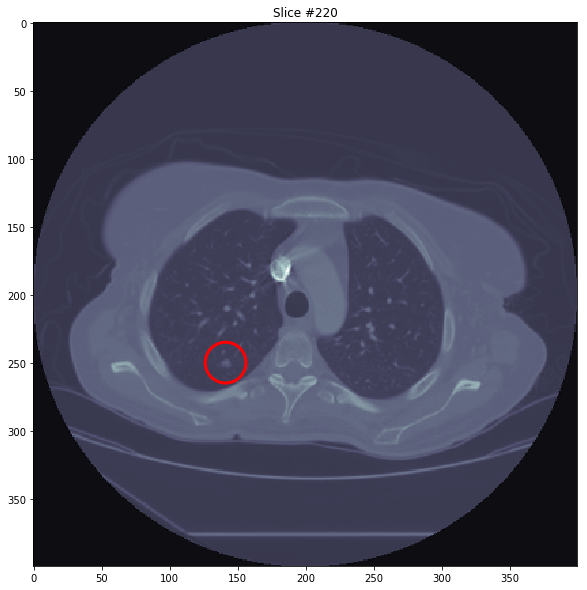

Voxel coord in Z, Y, X (with normalized spacing):  [206 182 101]


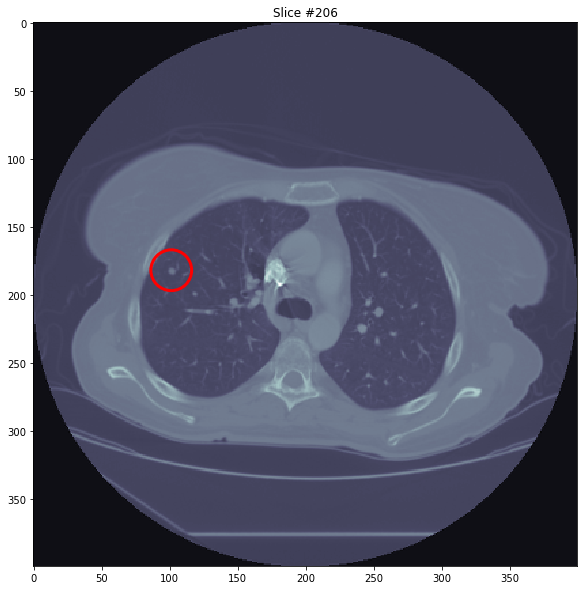

Voxel coord in Z, Y, X (with normalized spacing):  [226 256 249]


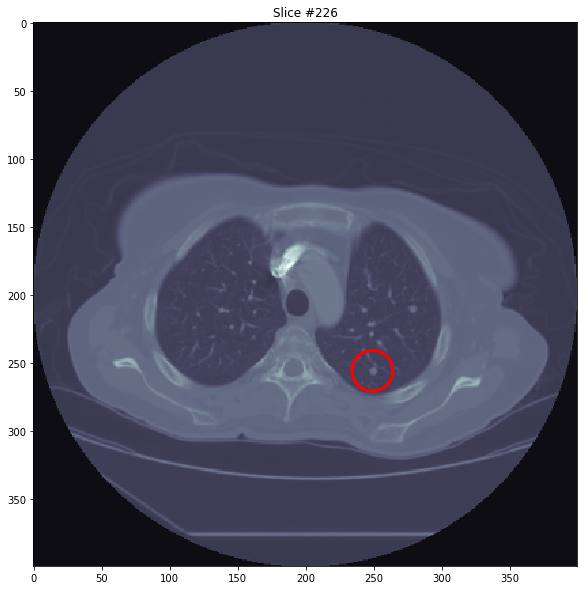

Voxel coord in Z, Y, X (with normalized spacing):  [159 178  69]


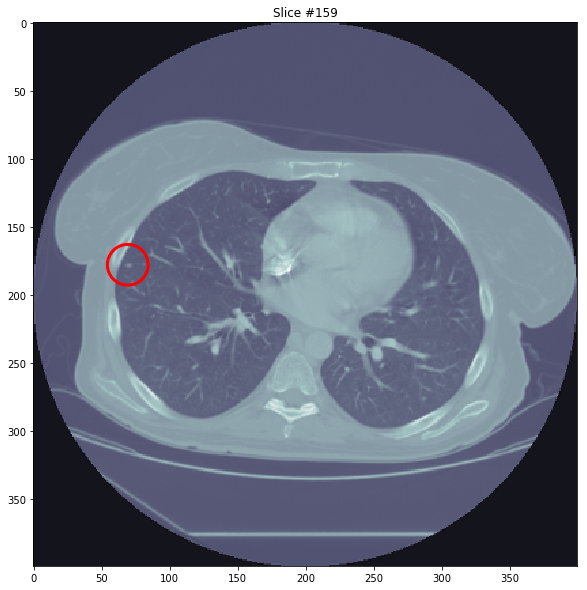

Voxel coord in Z, Y, X (with normalized spacing):  [143 238 180]


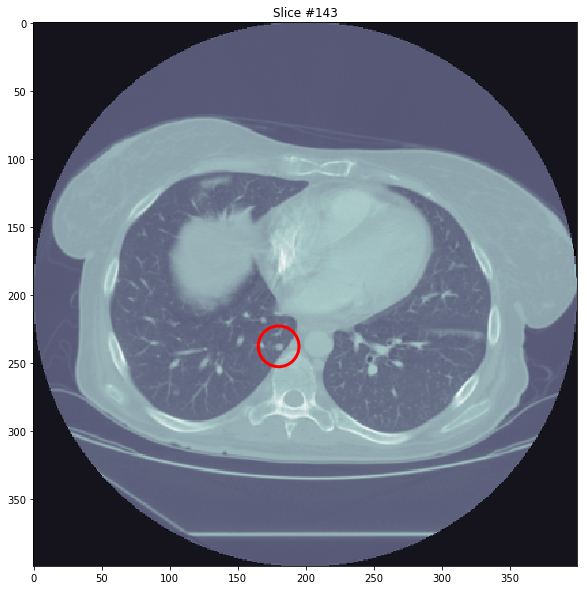

Voxel coord in Z, Y, X (with normalized spacing):  [225 210 278]


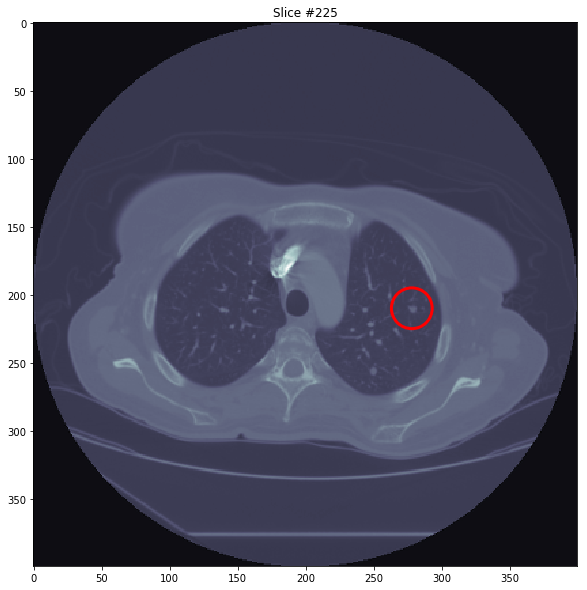

Voxel coord in Z, Y, X (with normalized spacing):  [215 241 267]


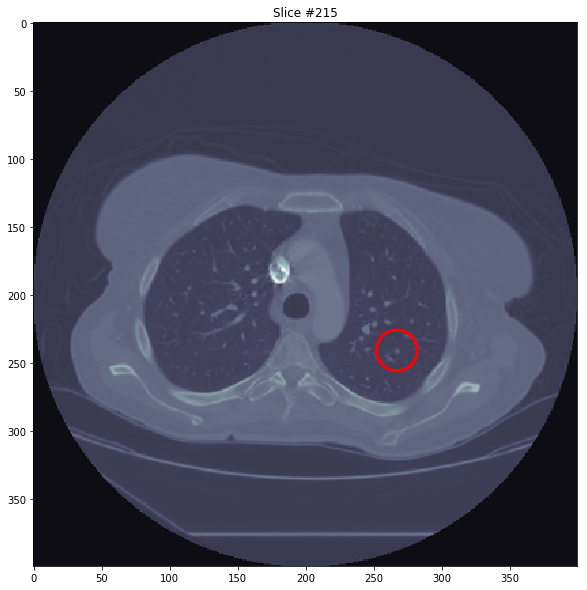

Voxel coord in Z, Y, X (with normalized spacing):  [172 223 306]


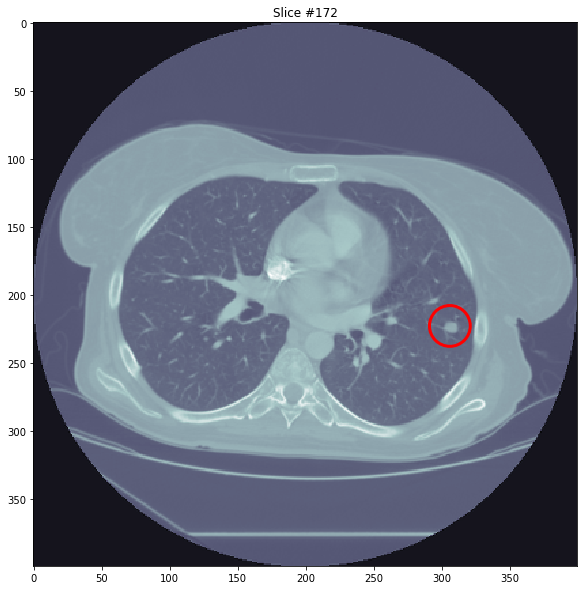

Nodules center found on Slice numbers [220, 206, 226, 159, 143, 225, 215, 172]


In [20]:
nodule_slices_lst = []
for cand in cands[1:]:
    worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
    voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing_Normalized)
    nodule_slices_lst.append(voxelCoord[0])

    fig,ax = plt.subplots(figsize=(10,10))
    print "Voxel coord in Z, Y, X (with normalized spacing): ", voxelCoord
    plt.imshow(img_np_array_norm[voxelCoord[0],:,:], cmap='bone');    

    circ = Circle((voxelCoord[2],voxelCoord[1]),15, lw=3.,fill=False, edgecolor='r') 
    ax.add_patch(circ)

    plt.title('Slice #{}'.format(voxelCoord[0]));
    plt.show() 
    
print ('Nodules center found on Slice numbers {}'.format(nodule_slices_lst) );

#### Uncomment the following cell to slide and view all the slices marked with center of a nodule. 

In [39]:
# def test(sliceNo):
#     fig,ax = plt.subplots(figsize=(20,20))
        
#     for cand in cands[1:9]:
#         worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
#         voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing_Normalized)
        
#         circ = Circle((voxelCoord[2],voxelCoord[1]),15, lw=3.,fill=False, edgecolor='r') 
#         if (sliceNo == voxelCoord[0]):
#             ax.add_patch(circ)
        
#     plt.imshow(img_np_array_norm[sliceNo-1,:,:], cmap='bone');    
    
#     plt.title('Slice #{}'.format(sliceNo));
#     plt.show()    
    
# print('Move the slider to go through the slices.')
# interact(test, sliceNo=(1,img_np_array_norm.shape[0],1));

Move the slider to go through the slices.


#### Following slider also shows the adjescent slices to the center of a specific nodule. As an example on slice 172, last annotation coordinate is marked and shown.

In [40]:
def test(sliceNo):
    fig,ax = plt.subplots(figsize=(10,10))
        
    plt.imshow(img_np_array_norm[sliceNo-1,:,:], cmap='bone');    
    worldCoord = np.asarray([float(cands[8][3]),float(cands[8][2]),float(cands[8][1])])
    voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing_Normalized)
    
    circ = Circle((voxelCoord[2],voxelCoord[1]),15, lw=3.,fill=False, edgecolor='r') 
    ax.add_patch(circ)

    plt.title('Slice #{}'.format(sliceNo));
    plt.show()    
    
print('Move the slider to go through the slices.')
interact(test, sliceNo=(1,img_np_array_norm.shape[0],1));

Move the slider to go through the slices.


### Segment out the patches around Voxel - in progress code
##### Currently the patch size is 60x60 mm, will upgrade to make the size user driven

In [41]:
img_np_array_norm.shape

(292, 400, 400)

Nodule coordinate is :  [220 250 141]
Patch data in 60x60 mm  :  
 [[-694 -787 -816 ..., -825 -830 -822]
 [-676 -687 -702 ..., -822 -829 -820]
 [-787 -756 -676 ..., -833 -836 -833]
 ..., 
 [ -14    0   28 ...,   46   40   40]
 [ -29  -20    0 ...,   46   39   41]
 [   9   21   31 ...,   65   67   70]]


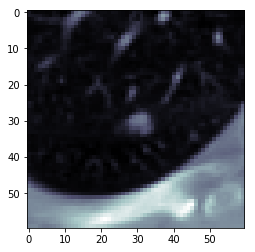

Nodule coordinate is :  [206 182 101]
Patch data in 60x60 mm  :  
 [[ -96 -101  -93 ..., -883 -888 -890]
 [-108 -105 -102 ..., -875 -897 -905]
 [-109  -97  -94 ..., -858 -876 -878]
 ..., 
 [ 371  470  399 ..., -775 -734 -707]
 [ 442  527  430 ..., -774 -776 -789]
 [ 494  539  433 ..., -350 -349 -427]]


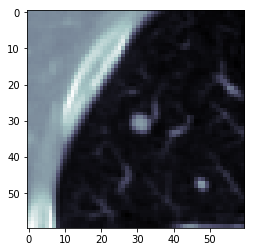

Nodule coordinate is :  [226 256 249]
Patch data in 60x60 mm  :  
 [[-630 -676 -733 ..., -774 -619 -376]
 [-687 -710 -724 ..., -849 -699 -484]
 [-734 -746 -738 ..., -851 -869 -809]
 ..., 
 [  41   34   31 ...,   21   28   19]
 [  25   32   26 ...,   48   50   53]
 [  38   43   33 ...,   21   38   41]]


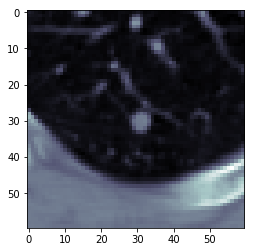

Nodule coordinate is :  [159 178  69]
Patch data in 60x60 mm  :  
 [[ -81 -100  -95 ..., -864 -861 -848]
 [ -54  -73  -85 ..., -859 -863 -844]
 [ -44  -36  -65 ..., -843 -858 -857]
 ..., 
 [ -99  -95 -100 ..., -766 -767 -706]
 [-105  -98 -100 ..., -779 -752 -683]
 [-106 -106 -107 ..., -809 -776 -742]]


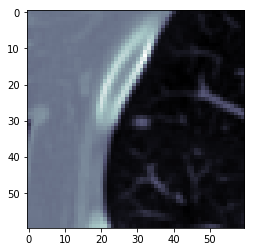

Nodule coordinate is :  [143 238 180]
Patch data in 60x60 mm  :  
 [[-842 -789 -778 ...,  286  284  278]
 [-804 -781 -797 ...,  277  282  298]
 [-812 -824 -810 ...,  291  286  284]
 ..., 
 [-839 -819 -790 ...,  140   25   -1]
 [-800 -811 -827 ...,  186   81   34]
 [-794 -798 -828 ...,  207  150   54]]


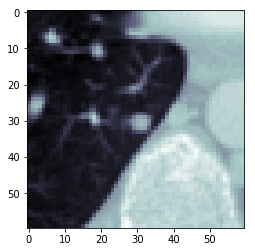

Nodule coordinate is :  [225 210 278]
Patch data in 60x60 mm  :  
 [[-822 -825 -817 ...,   46   55   10]
 [-817 -827 -832 ...,   47   55   45]
 [-833 -825 -825 ...,   36   47   50]
 ..., 
 [-793 -825 -832 ...,  431  143   30]
 [-778 -813 -818 ...,  420  116    7]
 [-787 -802 -807 ...,  367   71   -2]]


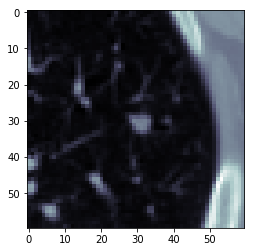

Nodule coordinate is :  [215 241 267]
Patch data in 60x60 mm  :  
 [[-697 -818 -818 ..., -845 -834 -825]
 [-691 -828 -820 ..., -834 -829 -784]
 [-786 -820 -821 ..., -831 -794 -691]
 ..., 
 [-619 -746 -809 ...,  560  183   15]
 [-651 -685 -749 ...,  120   -4   22]
 [-639 -605 -678 ...,    0   19   26]]


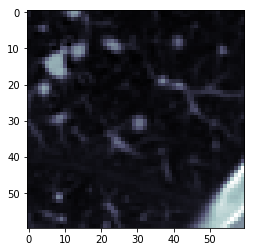

Nodule coordinate is :  [172 223 306]
Patch data in 60x60 mm  :  
 [[-815 -844 -833 ...,  -36  -83  -84]
 [-863 -855 -852 ...,  -40  -98  -84]
 [-841 -861 -865 ...,  -35  -93  -87]
 ..., 
 [-793 -794 -786 ...,  -48  -59  -40]
 [-796 -822 -741 ...,  -74  -54   -6]
 [-771 -809 -656 ...,  -67  -47  -20]]


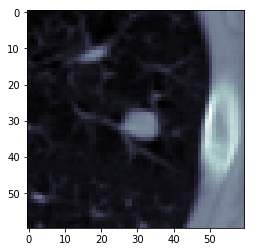

In [42]:
patchCoord_lst = []

for cand in cands[1:]:
    worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
    voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing_Normalized)
    
    patchWidth = 60 # as the maximum size of a Nodule can be upto 30 mm
     
    patch = img_np_array_norm[voxelCoord[0], \
                       voxelCoord[1] - 30 : voxelCoord[1] + 30, \
                       voxelCoord[2] - 30 : voxelCoord[2] + 30]
    
#    patch = normalizePlanes(patch) ....Anil:need to think on normalizing the Hounsfield scale Unit for each Patch 
    patchCoord_lst.append((voxelCoord,patch))

    print ('Nodule coordinate is :  {}'.format(voxelCoord) );
#     print ('Voxel value at nodule center is :  {}'.\
#            format(img_np_array_norm[voxelCoord[0], voxelCoord[1],voxelCoord[2]]) );
    
    print ('Patch data in 60x60 mm  :  \n {}'.format(patch) );
    plt.imshow(patch, cmap='bone')
    plt.show()    

In [25]:
#print patchCoord_lst

In [26]:
#AL -Reference

In [27]:
# AL - to del later
